In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from cmocean import cm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#cluster = PBSCluster(cores=28, processes=18, walltime='00:40:00')
w = cluster.scale(28)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.87:54157 Dashboard: http://10.148.1.87:8787/status,Cluster Workers: 21 Cores: 21 Memory: 359.94 GB


_________
# 1. Read dataset


In [21]:
out_dir_work = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_work+'U_total_rechunk.zarr').rename({'lon_g': 'lon'})
ds_V = xr.open_zarr(out_dir_work+'V_total_rechunk.zarr').rename({'lat_g': 'lat'})
ds = xr.merge([ds_U,ds_V,grid])
#ds = ds.rename({'lon_g': 'lon'})
#ds = ds.rename({'lat_g': 'lat'})

ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))
ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) floa

# 2. Filter

In [22]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/'

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

## 2.1 bandpass (1-5 days)

In [23]:
lowcut = 1/120/3600
highcut = 1/24/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, [low, high], 'bandpass')

In [24]:
U_bandpass_filter = butter_filter(ds.U.isel(time=slice(0,8761),depth=slice(0,40)), b, a)
V_bandpass_filter = butter_filter(ds.V.isel(time=slice(0,8761),depth=slice(0,40)), b, a)

## 2.2 low-pass (120 hours)

In [25]:
lowcut = 1/120/3600
highcut = 1/30/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

c, d = butter(4, low, 'low')

In [26]:
U_low_filter = butter_filter(ds.U.isel(time=slice(0,8761),depth=slice(0,40)), c, d)
V_low_filter = butter_filter(ds.V.isel(time=slice(0,8761),depth=slice(0,40)), c, d)

____________
## 3. KE

In [30]:
KE_low_filter = (U_low_filter**2 + V_low_filter**2)/2 # KE
KE_bandpass_filter = (U_bandpass_filter**2 + V_bandpass_filter**2)/2 # KE

KE_low_filter_smean = KE_low_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon'])
KE_bandpass_filter_smean = KE_bandpass_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon'])

KE_low_filter_smean = np.real(KE_low_filter_smean).rename('KE_low_filter_smean')     
KE_bandpass_filter_smean = np.real(KE_bandpass_filter_smean).rename('KE_bandpass_filter_smean')     

KE_mean = xr.merge([KE_low_filter_smean,KE_bandpass_filter_smean])
print(KE_mean)
file_out = out_dir_zarr+'/KE_mean.zarr'
KE_mean.to_zarr(file_out, mode='w')          

<xarray.Dataset>
Dimensions:                   (depth: 40, time: 8761)
Coordinates:
  * depth                     (depth) float64 0.5 1.57 2.79 ... 473.3 506.5
  * time                      (time) datetime64[ns] 2011-09-13 ... 2012-09-12
Data variables:
    KE_low_filter_smean       (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>
    KE_bandpass_filter_smean  (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>


In [31]:
# Read KE
ds_KE = xr.open_zarr(out_dir_zarr+'KE_mean.zarr')
ds_KE

<xarray.Dataset>
Dimensions:                   (depth: 40, time: 8761)
Coordinates:
  * depth                     (depth) float64 0.5 1.57 2.79 ... 473.3 506.5
  * time                      (time) datetime64[ns] 2011-09-13 ... 2012-09-12
Data variables:
    KE_bandpass_filter_smean  (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>
    KE_low_filter_smean       (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>

In [35]:
out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_MLD = ds_MLD.assign_coords(time=time_day) 
ds_MLD

<xarray.Dataset>
Dimensions:     (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Dimensions without coordinates: lat, lon
Data variables:
    mld_filter  (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

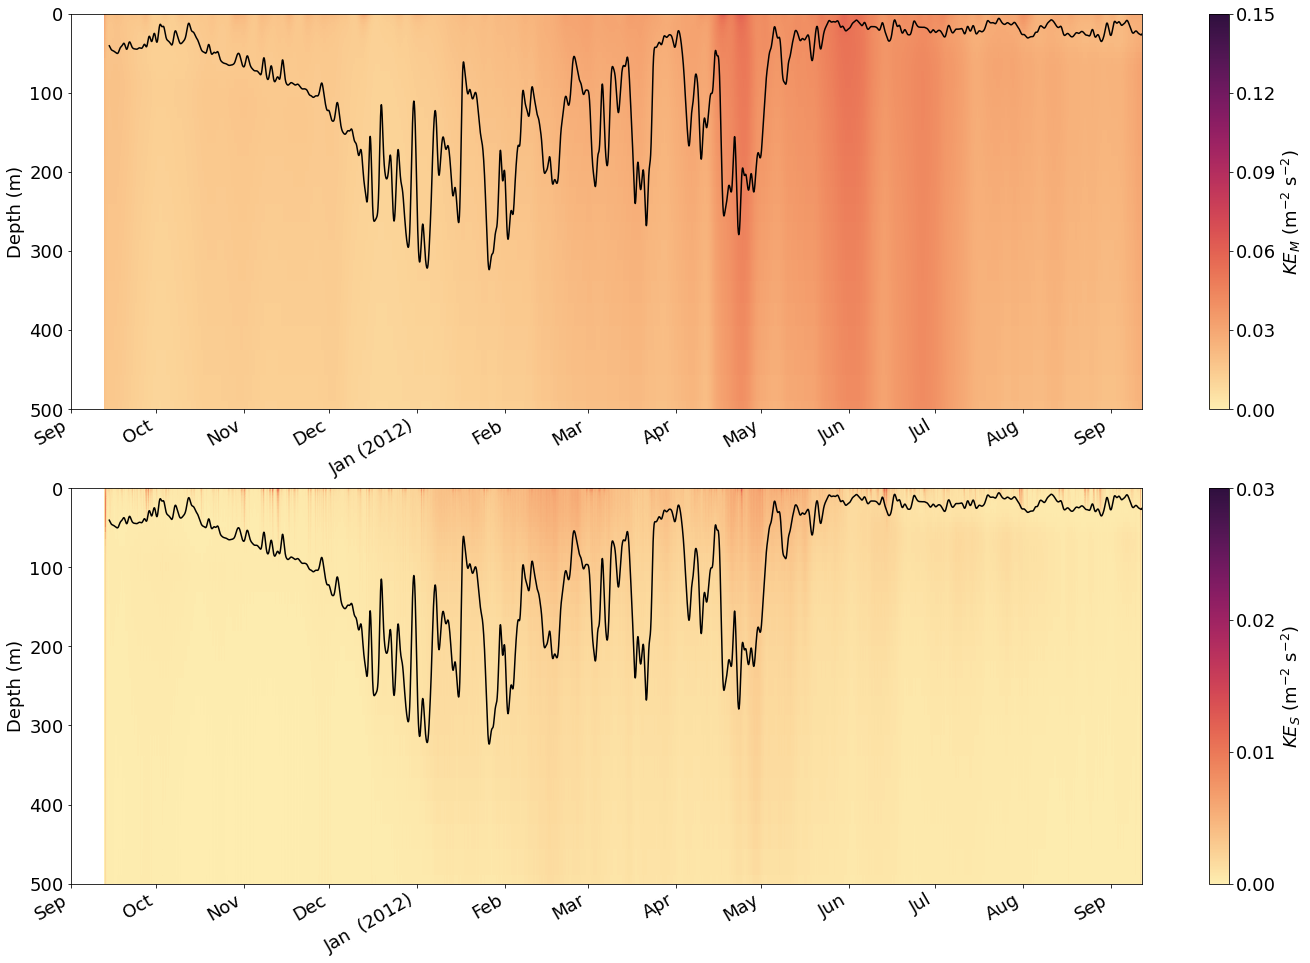

In [41]:
font_size = 18

fig = plt.figure(figsize=(24,16))
ax = plt.subplot(211)
cax=(ds_KE.KE_low_filter_smean).plot(x='time', y='depth', vmin=0, vmax=0.15, cmap=cm.matter, add_colorbar=False, yincrease=False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.03, 0.06, 0.09, 0.12, 0.15])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$KE_M$ (m$^{-2}$ s$^{-2}$)', fontsize=font_size)
ds_MLD.mld_filter.isel(time=slice(0,8761)).mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

ax = plt.subplot(212)
cax=(ds_KE.KE_bandpass_filter_smean).plot(x='time', y='depth', vmin=0, vmax=0.03, cmap=cm.matter, add_colorbar=False, yincrease=False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.01, 0.02, 0.03])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$KE_S$ (m$^{-2}$ s$^{-2}$)', fontsize=font_size)
ds_MLD.mld_filter.isel(time=slice(0,8761)).mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth (m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan  (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/KE.png')

In [42]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
